# Setup project

### Import environment

In [1]:

import tensorflow as tf
import json
import os
import cv2
import numpy as np
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, Model, optimizers, callbacks,regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
import matplotlib.pyplot as plt

# import data ready for training

## Edit data format

In [ ]:
import os
import shutil
import random

# Directory where your dataset is located
dataset_dir = 'path_to_dataset_directory'
train_dir = 'path_to_train_directory'
validation_dir = 'path_to_validation_directory'
test_dir = 'path_to_test_directory'

# Make directories for train, validation, and test sets if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Define the ratio for splitting the data
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

for class_folder in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_folder)
    images = os.listdir(class_path)
    random.shuffle(images)

    num_images = len(images)
    num_train = int(train_ratio * num_images)
    num_val = int(val_ratio * num_images)

    train_images = images[:num_train]
    val_images = images[num_train:num_train + num_val]
    test_images = images[num_train + num_val:]

    # Move images to the respective directories (train, validation, test)
    for img in train_images:
        src = os.path.join(class_path, img)
        dst = os.path.join(train_dir, class_folder, img)
        os.makedirs(os.path.join(train_dir, class_folder), exist_ok=True)
        shutil.copy(src, dst)

    for img in val_images:
        src = os.path.join(class_path, img)
        dst = os.path.join(validation_dir, class_folder, img)
        os.makedirs(os.path.join(validation_dir, class_folder), exist_ok=True)
        shutil.copy(src, dst)

    for img in test_images:
        src = os.path.join(class_path, img)
        dst = os.path.join(test_dir, class_folder, img)
        os.makedirs(os.path.join(test_dir, class_folder), exist_ok=True)
        shutil.copy(src, dst)

## Import and do augmentation

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = '/Users/tai/project for everything/hand_lang/extreme_dataset/train'
validation_dir = '/Users/tai/project for everything/hand_lang/extreme_dataset/validation'
test_dir = '/Users/tai/project for everything/hand_lang/extreme_dataset/test'

# Define batch size and target size
batch_size = 32
target_size = (224, 224)  # Adjust according to the input size expected by your model

# Function to apply blur to images
def apply_blur(image):
    blurred = cv2.GaussianBlur(image, (5, 5), 0)  # You can adjust the kernel size for the blur effect
    return blurred

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.5, 1.5],  # Adjust the range for brightness
    channel_shift_range=50,  # This will change the hue
    preprocessing_function=apply_blur  # Applying blur using the defined function
)
# Data normalization for validation and test data (no augmentation)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches using train_datagen
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Flow validation images in batches using validation_datagen
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Flow test images in batches using test_datagen
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # To keep the order of the images
)

Found 17654 images belonging to 11 classes.
Found 3781 images belonging to 11 classes.
Found 3795 images belonging to 11 classes.


# MODEL MobileNetv2

In [3]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),include_top=False,weights="imagenet")

9406464/9406464 [==============================] - 3s 0us/step


In [4]:
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

In [10]:
# base_model.summary()

In [11]:
len(base_model.layers)

154

### Custom head

In [5]:
# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)  # Adding dropout
num_class = 11
predictions = Dense(num_class, activation='softmax')(x)  # 'num_classes' should match your dataset's classes
model = Model(inputs=base_model.input, outputs=predictions)

# model.summary()

In [6]:
len(model.layers)

158

### Training Function

In [7]:
# Define a custom callback to save history every epoch
class SaveHistory(Callback):
    def __init__(self, filename):
        self.filename = filename

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}

        # Load existing history if the file exists
        if os.path.exists(self.filename):
            with open(self.filename, 'r') as history_file:
                existing_history = json.load(history_file)
            for key, value in existing_history.items():
                self.model.history.history.setdefault(key, []).extend(value)

        # Append new data to the history
        self.model.history.epoch.append(epoch)
        self.model.history.history.setdefault('loss', []).append(logs.get('loss'))
        self.model.history.history.setdefault('accuracy', []).append(logs.get('accuracy'))
        self.model.history.history.setdefault('val_loss', []).append(logs.get('val_loss'))
        self.model.history.history.setdefault('val_accuracy', []).append(logs.get('val_accuracy'))

        # Save the updated history to a JSON file
        with open(self.filename, 'w') as history_file:
            json.dump(self.model.history.history, history_file)

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Define the checkpoint callback to save model checkpoints every 5 epochs
checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/My Drive/trained model/mobilenetv2.h5',
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    save_freq=3,
    verbose=1
)

# Example of reducing learning rate on a plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.000001)


### Fine Tuning

In [8]:
model.trainable = True

In [9]:
for layer in model.layers[:80]:
  layer.trainable=False

In [17]:
# To see which layers are trainable
for layer in model.layers:
    print(f"Layer: {layer.name} - Trainable: {layer.trainable}")

Layer: input_1 - Trainable: False
Layer: Conv1 - Trainable: False
Layer: bn_Conv1 - Trainable: False
Layer: Conv1_relu - Trainable: False
Layer: expanded_conv_depthwise - Trainable: False
Layer: expanded_conv_depthwise_BN - Trainable: False
Layer: expanded_conv_depthwise_relu - Trainable: False
Layer: expanded_conv_project - Trainable: False
Layer: expanded_conv_project_BN - Trainable: False
Layer: block_1_expand - Trainable: False
Layer: block_1_expand_BN - Trainable: False
Layer: block_1_expand_relu - Trainable: False
Layer: block_1_pad - Trainable: False
Layer: block_1_depthwise - Trainable: False
Layer: block_1_depthwise_BN - Trainable: False
Layer: block_1_depthwise_relu - Trainable: False
Layer: block_1_project - Trainable: False
Layer: block_1_project_BN - Trainable: False
Layer: block_2_expand - Trainable: False
Layer: block_2_expand_BN - Trainable: False
Layer: block_2_expand_relu - Trainable: False
Layer: block_2_depthwise - Trainable: False
Layer: block_2_depthwise_BN - Trai

In [6]:
#load model that already train
model = tf.keras.models.load_model('/content/drive/My Drive/hand_language_model/MobileNetV2_10epoch_with_finetune.h5')

In [10]:
# Define the custom history-saving callback
# history_saver = SaveHistory('/content/drive/MyDrive/hand_language_model/mobilenetv2_history.json')

# Reduce the learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Add the custom callback to the list of callbacks during training
# callbacks = [early_stopping, checkpoint_callback, history_saver]

In [11]:
# Calculate the total number of training and validation samples
num_train_samples = len(train_generator.filenames)  # total number of training samples
num_val_samples = len(validation_generator.filenames)  # total number of validation samples

history = model.fit_generator(
    train_generator,
    steps_per_epoch=num_train_samples // batch_size,
    epochs=10,  # Train for additional epochs
    validation_data=validation_generator,
    validation_steps=num_val_samples // batch_size,
    callbacks=[early_stopping,reduce_lr]
)

/var/folders/kc/w9l6xj056fn5vq583fjcnqg00000gn/T/ipykernel_26407/1582212641.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10
551/551 [==============================] - 280s 504ms/step - loss: 8.6614 - accuracy: 0.7854 - val_loss: 5.3581 - val_accuracy: 0.9179 - lr: 1.0000e-04
Epoch 2/10
242/551 [============>.................] - ETA: 2:47 - loss: 4.3050 - accuracy: 0.9456

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
# Extract training history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Create subplots for loss and accuracy
plt.figure(figsize=(12, 4))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Time')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Time')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
model.save('/Users/tai/project for everything/hand_lang/extreme_dataset/extreme_model_10epoch')

# Load model and evaluate

In [ ]:
model = tf.keras.models.load_model('/Users/tai/project for everything/hand_lang/extreme_dataset/extreme_model_10epoch')

In [ ]:
evaluation = model.evaluate_generator(test_generator)

# The evaluation result will contain the loss and metrics values
loss = evaluation[0]
accuracy = evaluation[1]

print(f'Validation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

In [22]:
model = tf.keras.models.load_model('/content/drive/My Drive/hand_language_model/MobileNetV2_30epoch_with_finetune.h5')

In [23]:
evaluation = model.evaluate_generator(test_generator)

# The evaluation result will contain the loss and metrics values
loss = evaluation[0]
accuracy = evaluation[1]

print(f'Validation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

<ipython-input-23-bf3fc3eda983>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  evaluation = model.evaluate_generator(test_generator)


Validation Loss: 0.0856
Validation Accuracy: 98.10%


# Model comparision

In [ ]:
# Load the training history from MOBILENETV2
with open('/content/drive/MyDrive/hand_language_model/mobilenetv2_history.json', 'r') as history_file:
    history_data = json.load(history_file)

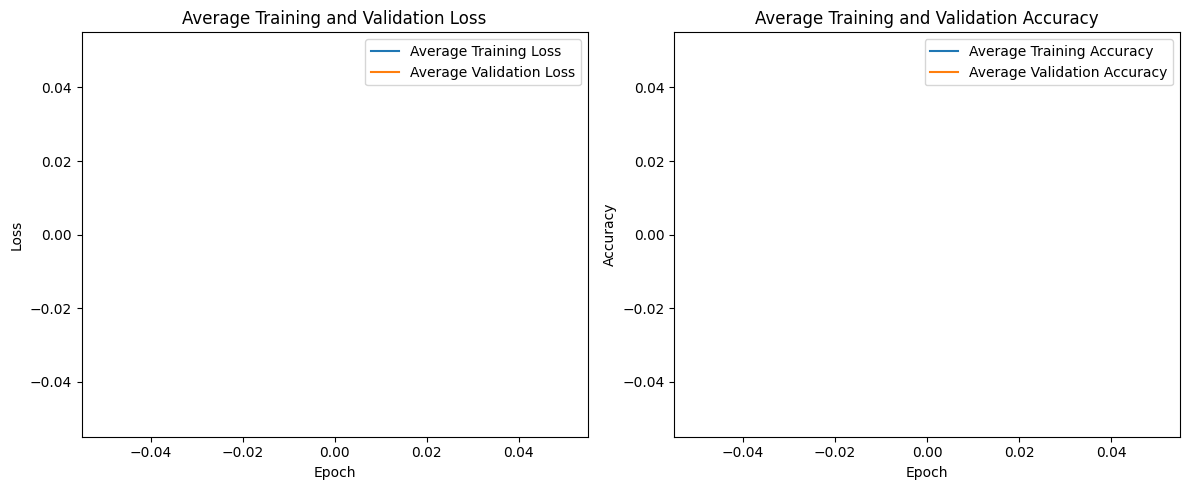

In [ ]:
# Get the number of values per metric
num_values_per_metric = len(history_data['loss'])

# Calculate the number of epochs
num_epochs = num_values_per_metric // 400  # Assuming 11 steps per epoch

# Initialize lists to store average values
average_training_loss = []
average_training_accuracy = []
average_validation_loss = []
average_validation_accuracy = []

# Calculate the average values for each epoch
for epoch in range(num_epochs):
    start_idx = epoch * 11
    end_idx = start_idx + 11

    epoch_training_loss = np.mean(history_data['loss'][start_idx:end_idx])
    epoch_training_accuracy = np.mean(history_data['accuracy'][start_idx:end_idx])
    epoch_validation_loss = np.mean(history_data['val_loss'][start_idx:end_idx])
    epoch_validation_accuracy = np.mean(history_data['val_accuracy'][start_idx:end_idx])

    average_training_loss.append(epoch_training_loss)
    average_training_accuracy.append(epoch_training_accuracy)
    average_validation_loss.append(epoch_validation_loss)
    average_validation_accuracy.append(epoch_validation_accuracy)

# Create plots for average loss and accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot the average training and validation loss
plt.subplot(1, 2, 1)
plt.plot(average_training_loss, label='Average Training Loss')
plt.plot(average_validation_loss, label='Average Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Average Training and Validation Loss')

# Plot the average training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(average_training_accuracy, label='Average Training Accuracy')
plt.plot(average_validation_accuracy, label='Average Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Average Training and Validation Accuracy')

plt.tight_layout()
plt.show()